# State Estimation

In [1]:
import numpy as np

import sox.battery.protocol as protocol
from sox.estimator import SOCWithEKF, SOCWithUKF
from sox.battery import Thevenin, default_thevenin_inputs
from sox.sensor import Sensor, Normal, StuckAt, Drift
from sox.filter import CoulombCount, ExtendedKalmanFilter, UnscentedKalmanFilter, MerweSigmaPoints

# Synthetic Ground-truth Data

In [2]:
battery = Thevenin(default_thevenin_inputs)

dt = 1.0
solution = battery.solve(protocol.charge_discharge_cycling(number_of_cycles=2, sampling_time_s=dt))

time = solution.time
voltage = solution.voltage
current = solution.current
soc = solution.soc
cell_temperature = solution.cell_temperature

# State Estimators

In [3]:
# sets up the coulomb counter

capacity = 10  # real value: 10
initial_soc = 0.75  # real value: 0.8
soc_with_coulomb_count = CoulombCount(initial_soc, capacity, dt)


# sets up the extended kalman filter
# assumes time-invariant model parameters and state transition

rc_pairs = 1  # real value: 1
capacity = 10  # real value: 10
initial_soc = 0.75  # real value: 0.8
ocv_func = default_thevenin_inputs.open_circuit_voltage
r0 = 4.5e-4  # real value: variable
r1 = 6e-4  # real value: variable
c1 = 5e4  # real value: variable
a1 = np.exp(-dt / (r1 * c1))

ekf = ExtendedKalmanFilter(
    F=np.diag([1.0, a1]),  # state transition matrix
    B=np.array([-dt / capacity / 3600, r1 * (1 - a1)])[:, np.newaxis],  # input matrix
    Q=np.diag([1e-5, 1e-5]),  # process noise
    R=np.array([[1e-5]]),  # measurement noise
    x0=np.array([initial_soc, 0.0])[:, np.newaxis],  # initial states [soc, v_rc1]
    P0=np.diag([0.005, 0.02]),  # initial covariance of states
)
soc_with_ekf = SOCWithEKF(ocv_func, rc_pairs)


# sets up the unscented kalman filter

ukf = UnscentedKalmanFilter(
    Q=np.diag([1e-5, 1e-5]),
    R=np.array([[1e-5]]),
    x0=np.array([initial_soc, 0.0])[:, np.newaxis],
    P0=np.diag([0.005, 0.02]),
    sigma_gen=MerweSigmaPoints(n=2, alpha=1e-3, beta=2.0, kappa=0.0),
)
soc_with_ukf = SOCWithUKF(ocv_func, [r1], [c1], capacity)

# Sensors

In [4]:
# sets up the sensors

voltage_sensor = Sensor(
    name="voltage sensor",
    time=time,
    data=voltage,
    noise=Normal(0, 0.002),
    faults=[
        StuckAt(start_time=2000, stop_time=2500, value=3.0),
        Drift(start_time=0, stop_time=12000, rate=-0.02 / 3600),
    ],
)

current_sensor = Sensor(
    name="current sensor",
    time=time,
    data=current,
    noise=Normal(0, 0.1),
    faults=[
        StuckAt(start_time=500, stop_time=1000, value=0.0),
        Drift(start_time=0, stop_time=12000, rate=-0.2 / 3600),
    ],
)

temperature_sensor = Sensor(
    name="temperature sensor",
    time=time,
    data=cell_temperature,
    noise=Normal(0, 0.1),
    faults=[
        StuckAt(start_time=7000, stop_time=7500, value=30),
        Drift(start_time=0, stop_time=12000, rate=0.1 / 3600),
    ],
)

sensors = [voltage_sensor, current_sensor, temperature_sensor]

# Run Estimation

In [5]:
# runs the state estimation

v_sense = []
curr_sense = []
temp_sense = []
soc_cc = []
soc_ekf = []
soc_ukf = []

# try:
for s in sensors:
    s.reset()
while True:
    # sensor readings
    voltage_reading, current_reading, temperature_reading = [s.read() for s in sensors]

    # coulomb counting
    soc_with_coulomb_count.update(current_reading)

    # extended kalman filter
    ekf.predict(u=np.array([[current_reading]]))
    ekf.update(
        z=voltage_reading,
        hx=soc_with_ekf.hx,
        h_jacobian=soc_with_ekf.h_jacobian,
        hj_args=(),
        hx_args=(r0, current_reading),
    )

    ukf.predict(fx=soc_with_ukf.fx, fx_args=(current_reading, dt))
    ukf.update(
        z=voltage_reading,
        hx=soc_with_ukf.hx,
        hx_args=(r0, current_reading),
    )

    # store states and sensor readings
    soc_cc.append(soc_with_coulomb_count.soc)
    soc_ekf.append(ekf.x[0, 0])
    soc_ukf.append(ukf.x[0, 0])

    v_sense.append(voltage_reading)
    curr_sense.append(current_reading)
    temp_sense.append(temperature_reading)

# except Exception as e:
#     print(e)

IndexError: Sensor 'voltage sensor' finished reading.

# Plot Results

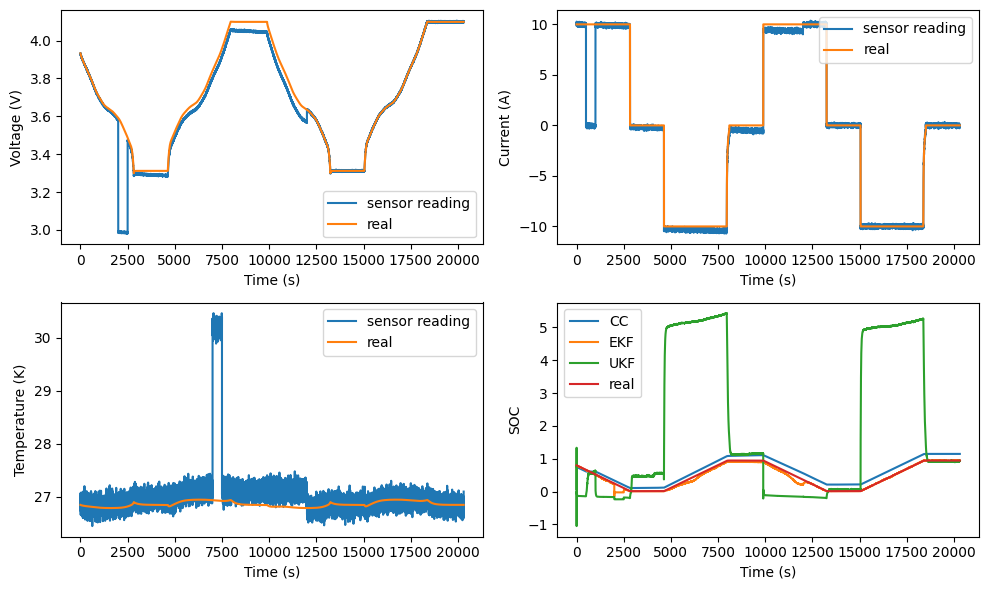

In [6]:
from sox.utils import quick_plot

quick_plot(
    time=time,
    data=[[v_sense, voltage], [curr_sense, current], [temp_sense, cell_temperature], [soc_cc, soc_ekf, soc_ukf, soc]],
    legend=[
        ["sensor reading", "real"],
        ["sensor reading", "real"],
        ["sensor reading", "real"],
        ["CC", "EKF", "UKF", "real"],
    ],
    x_label="Time (s)",
    y_label=["Voltage (V)", "Current (A)", "Temperature (K)", "SOC"],
)